## IMPLEMENTATION


Importing Libraries

In [ ]:
import os
import zipfile
import requests
from pathlib import Path
import json
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from transformers import BertTokenizer, BertModel
import random
import shutil


Getting Dataset

In [ ]:
# ------------------------
# CONFIG
# ------------------------
class CFG:
    data_dir = Path("flickr8k_data")
    images_zip_url = "https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip"
    text_zip_url = "https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip"
    images_dir = data_dir / "Flickr8k_Dataset"
    # Fixing images
    nested_images_dir = data_dir / "Flickr8k_Dataset" / "Flickr8k_Dataset"
    text_dir = data_dir / "Flickr8k_text"
    prepared_json = data_dir / "captions.json"
    train_list = data_dir / "Flickr_8k.trainImages.txt"
    val_list = data_dir / "Flickr_8k.devImages.txt"
    test_list = data_dir / "Flickr_8k.testImages.txt"
    batch_size = 32
    lr = 3e-5
    epochs = 10
    device = "cuda" if torch.cuda.is_available() else "cpu"
    max_len = 30
    embed_dim = 256
    seed = 42
    num_workers = 2

random.seed(CFG.seed)
torch.manual_seed(CFG.seed)


In [ ]:
# ------------------------
# download & extract
# ------------------------
def download_file(url, out_path, desc=None):
    out_path.parent.mkdir(parents=True, exist_ok=True)
    if out_path.exists():
        print(f"{out_path} already exists, skipping download.")
        return
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        total = int(r.headers.get("content-length", 0))
        with open(out_path, "wb") as f, tqdm(
            desc=(desc or out_path.name),
            total=total,
            unit="iB",
            unit_scale=True,
        ) as bar:
            for chunk in r.iter_content(chunk_size=1024*1024):
                if chunk:
                    f.write(chunk)
                    bar.update(len(chunk))

def safe_unzip(zip_path, dest):
    with zipfile.ZipFile(zip_path, 'r') as z:
        z.extractall(dest)


Fixing Folder Structure

In [ ]:
# -------------------------------------------------
# Fixing folder structure & missing files handling
# -------------------------------------------------
def fix_folder_structure():
    # If images were extracted into nested folder Flickr8k_Dataset/Flickr8k_Dataset, move them up
    nested = CFG.nested_images_dir
    root = CFG.images_dir
    if nested.exists() and nested.is_dir():
        print("Fixing double-nested Flickr8k folder structure...")
        for file in nested.iterdir():
            if file.is_file():
                dst = root / file.name
                # move file up
                shutil.move(str(file), str(dst))
        # remove nested folder if empty
        try:
            nested.rmdir()
        except Exception:
            # if not empty, attempt rmtree to delete
            shutil.rmtree(nested)
        print("Folder structure fixed")

**Preparing Data**

In [ ]:
# ------------------------
# PREPARE DATA
# ------------------------
def prepare_flickr8k():

    CFG.data_dir.mkdir(parents=True, exist_ok=True)

    images_zip = CFG.data_dir / "Flickr8k_Dataset.zip"
    text_zip = CFG.data_dir / "Flickr8k_text.zip"

    # Download zips
    print("Downloading image zip...")
    download_file(CFG.images_zip_url, images_zip, desc="Images ZIP")
    print("Downloading text zip...")
    download_file(CFG.text_zip_url, text_zip, desc="Text ZIP")

    # Extract
    print("Extracting images...")
    safe_unzip(images_zip, CFG.data_dir)
    print("Extracting text files...")
    safe_unzip(text_zip, CFG.data_dir)

    # fixing possible double nested extraction
    fix_folder_structure()

    possible_token_paths = [
        CFG.data_dir / "Flickr8k.token.txt",
        CFG.data_dir / "Flickr8k_text" / "Flickr8k.token.txt",
        CFG.data_dir / "Flickr8k_text" / "Flickr8k.token.txt.txt",
    ]
    token_path = None
    for p in possible_token_paths:
        if p.exists():
            token_path = p
            break
    if token_path is None:
        raise FileNotFoundError("Could not find Flickr8k.token.txt after extraction.")

    print(f"Parsing captions from {token_path} ...")
    caps = {}
    with open(token_path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            try:
                imgcap_id, caption = line.split("\t")
            except ValueError:
                # some lines might not follow expected format; skip them
                continue
            img_name = imgcap_id.split("#")[0]
            caption = caption.strip()
            caps.setdefault(img_name, []).append(caption)

    # saving simplified JSON
    with open(CFG.prepared_json, "w", encoding="utf-8") as fout:
        json.dump(caps, fout, ensure_ascii=False, indent=2)

    # copy train/dev/test lists if present inside text zip
    for fname in ["Flickr_8k.trainImages.txt", "Flickr_8k.devImages.txt", "Flickr_8k.testImages.txt"]:
        p = CFG.data_dir / fname
        if not p.exists():
            alt = CFG.data_dir / "Flickr8k_text" / fname
            if alt.exists():
                alt.rename(p)
    print("Prepared captions.json and splits. Done.")

In [ ]:
# -----------------------------------------
# DATASET CLASS (robust to missing images)
# -----------------------------------------
class FlickrRetrievalDataset(Dataset):
    def __init__(self, images_root, captions_json, image_list=None, tokenizer=None, transform=None):
        self.images_root = Path(images_root)
        with open(captions_json, "r", encoding="utf-8") as f:
            self.caps = json.load(f)
        # filter out images whose files are missing
        available = []
        for name in self.caps.keys():
            if (self.images_root / name).exists():
                available.append(name)
        if image_list:
            # keeping only those that are both in split list and available on disk
            image_list_set = set(image_list)
            available = [n for n in available if n in image_list_set]
        self.img_names = sorted(available)
        print(f"Dataset: {len(self.img_names)} images available for this split.")
        self.tokenizer = tokenizer
        self.transform = transform

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_name = self.img_names[idx]
        img_path = self.images_root / img_name
        try:
            img = Image.open(img_path).convert("RGB")
        except Exception:
            # if image corrupted or cannot be opened, return a random other image to avoid crashing worker
            alt_idx = random.randint(0, len(self.img_names)-1)
            alt_name = self.img_names[alt_idx]
            img = Image.open(self.images_root / alt_name).convert("RGB")

        if self.transform:
            img = self.transform(img)

        # sample one caption randomly for this image
        captions = self.caps.get(img_name, [""])
        caption = random.choice(captions)

        encoded = self.tokenizer(
            caption,
            padding="max_length",
            truncation=True,
            max_length=CFG.max_len,
            return_tensors="pt",
        )
        return img, encoded["input_ids"][0], encoded["attention_mask"][0], img_name

In [ ]:
# ------------------------
#  MODELS
# ------------------------
class ImageEncoder(nn.Module):         #pythorch module. to convert image into emberdding
    def __init__(self, embed_dim=CFG.embed_dim):   #embed_dim final vector where both image and text map
        super().__init__()
        model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1) #pretrained resnet model
        model.fc = nn.Identity() #remove last layer (now only features vector 512_dim)
        self.cnn = model  #resnet model save
        self.fc = nn.Linear(512, embed_dim)

    def forward(self, x):
        feat = self.cnn(x)  #pass image to resnet. get vector
        return F.normalize(self.fc(feat), dim=-1)  # pass from linear layer embedding done

class TextEncoder(nn.Module):  #text embedding encoder
    def __init__(self, embed_dim=CFG.embed_dim):
        super().__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.fc = nn.Linear(768, embed_dim)

    def forward(self, ids, mask): #Tokens + attention mask -> BERT -> hidden states + pooled output return
        out = self.bert(ids, mask)
        cls = out.pooler_output  #token ka embedding use as a sentence rep
        return F.normalize(self.fc(cls), dim=-1)

def contrastive_loss(img_emb, txt_emb, temp=0.07): #clip style contrative loss
    logits = img_emb @ txt_emb.t() / temp #Image embeddings × text embeddings dot-product similarity -> (N×N matrix).Temperature to scale (higher sharpness) @matrix multiplication operator
    labels = torch.arange(len(logits)).to(CFG.device)  #correct pairs are diagonal
    loss_i = nn.functional.cross_entropy(logits, labels)  #classify text for every image (Image->Text loss)
    loss_t = nn.functional.cross_entropy(logits.t(), labels) #for every text classify correct image (Text->Image loss)
    return (loss_i + loss_t) / 2.0  #avg of both loss

In [ ]:
# ------------------------
# TRAIN + EVALUATION
# ------------------------
def read_split_list(path):
    if not path.exists():
        return None
    with open(path, "r") as f:
        return [ln.strip() for ln in f if ln.strip()]

def build_dataloaders():
    # tokenizer + transforms
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
    ])

    train_list = read_split_list(CFG.train_list)
    val_list = read_split_list(CFG.val_list)
    test_list = read_split_list(CFG.test_list)

    train_ds = FlickrRetrievalDataset(CFG.images_dir, CFG.prepared_json, image_list=train_list, tokenizer=tokenizer, transform=transform)
    val_ds = FlickrRetrievalDataset(CFG.images_dir, CFG.prepared_json, image_list=val_list, tokenizer=tokenizer, transform=transform)
    test_ds = FlickrRetrievalDataset(CFG.images_dir, CFG.prepared_json, image_list=test_list, tokenizer=tokenizer, transform=transform)

    train_loader = DataLoader(train_ds, batch_size=CFG.batch_size, shuffle=True, num_workers=CFG.num_workers, pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size=CFG.batch_size, shuffle=False, num_workers=CFG.num_workers, pin_memory=True)
    test_loader = DataLoader(test_ds, batch_size=CFG.batch_size, shuffle=False, num_workers=CFG.num_workers, pin_memory=True)

    return train_loader, val_loader, test_loader, tokenizer

def train():
    print("Preparing dataset (download + extract) ...")
    prepare_flickr8k()   # download & prepare captions.json and splits
    train_loader, val_loader, test_loader, tokenizer = build_dataloaders()

    img_enc = ImageEncoder().to(CFG.device)
    txt_enc = TextEncoder().to(CFG.device)

    optimizer = torch.optim.AdamW(list(img_enc.parameters()) + list(txt_enc.parameters()), lr=CFG.lr)

    for epoch in range(1, CFG.epochs+1):
        img_enc.train(); txt_enc.train()
        total_loss = 0.0
        iters = 0
        for imgs, ids, masks, _ in tqdm(train_loader, desc=f"Epoch {epoch}/{CFG.epochs}"):
            imgs = imgs.to(CFG.device)
            ids = ids.to(CFG.device)
            masks = masks.to(CFG.device)

            img_emb = img_enc(imgs)
            txt_emb = txt_enc(ids, masks)
            loss = contrastive_loss(img_emb, txt_emb)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item(); iters += 1

        avg_loss = total_loss / max(1, iters)
        print(f"Epoch {epoch} avg loss: {avg_loss:.4f}")

        # Save checkpoints each epoch
        torch.save(img_enc.state_dict(), f"image_enc_epoch{epoch}.pth")
        torch.save(txt_enc.state_dict(), f"text_enc_epoch{epoch}.pth")

    print("Training finished. Encoders saved.")


In [ ]:


# ------------------------
#   SIMPLE INFERENCE FUNCTIONS
# ------------------------
@torch.no_grad()
def build_embedding_table(img_enc, txt_enc, tokenizer, max_items=None):
    # build image embeddings and text embeddings (one caption per image: use first caption)
    with open(CFG.prepared_json, "r", encoding="utf-8") as f:
        caps = json.load(f)
    image_names = sorted(list(caps.keys()))
    if max_items:
        image_names = image_names[:max_items]

    # filter out missing images
    image_names = [n for n in image_names if (CFG.images_dir / n).exists()]

    img_enc.eval(); txt_enc.eval()
    image_embs = []
    text_embs = []
    captions = []
    names = []
    transform = transforms.Compose([
        transforms.Resize((224,224)), transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
    ])

    for name in tqdm(image_names, desc="Building tables"):
        img = Image.open(CFG.images_dir / name).convert("RGB")
        img_t = transform(img).unsqueeze(0).to(CFG.device)
        emb_i = img_enc(img_t).cpu()
        # use first caption deterministically
        cap = caps[name][0]
        enc = tokenizer(cap, truncation=True, padding="max_length", max_length=CFG.max_len, return_tensors="pt")
        emb_t = txt_enc(enc["input_ids"].to(CFG.device), enc["attention_mask"].to(CFG.device)).cpu()
        image_embs.append(emb_i.squeeze(0))
        text_embs.append(emb_t.squeeze(0))
        captions.append(cap)
        names.append(name)

    image_embs = torch.stack(image_embs) if len(image_embs) > 0 else torch.empty(0, CFG.embed_dim)
    text_embs = torch.stack(text_embs) if len(text_embs) > 0 else torch.empty(0, CFG.embed_dim)
    return image_embs, text_embs, captions, names

@torch.no_grad()
def text_to_image(query, img_enc, txt_enc, tokenizer, topk=5):
    enc = tokenizer(query, truncation=True, padding="max_length", max_length=CFG.max_len, return_tensors="pt")
    q_emb = txt_enc(enc["input_ids"].to(CFG.device), enc["attention_mask"].to(CFG.device)).cpu()
    image_embs, _, captions, names = build_embedding_table(img_enc, txt_enc, tokenizer)
    if image_embs.numel() == 0:
        return []
    sims = (q_emb @ image_embs.t()).squeeze(0)
    vals, idxs = sims.topk(min(topk, len(names)))
    return [(names[i.item()], float(vals[j].item()), captions[i.item()]) for j,i in enumerate(idxs)]

# ------------------------
#  ENTRY
# ------------------------
if __name__ == "__main__":
    train()



Preparing dataset (download + extract) ...
flickr8k_data/Flickr8k_Dataset.zip already exists, skipping download.
flickr8k_data/Flickr8k_text.zip already exists, skipping download.
Extracting images...
Extracting text files...
Parsing captions from flickr8k_data/Flickr8k.token.txt ...
Prepared captions.json and splits. Done.
Dataset: 6000 images available for this split.
Dataset: 1000 images available for this split.
Dataset: 1000 images available for this split.
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 181MB/s]


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Epoch 1/10: 100%|██████████| 188/188 [01:02<00:00,  3.00it/s]


Epoch 1 avg loss: 2.4208


Epoch 2/10: 100%|██████████| 188/188 [00:55<00:00,  3.38it/s]


Epoch 2 avg loss: 1.3033


Epoch 3/10: 100%|██████████| 188/188 [00:54<00:00,  3.42it/s]


Epoch 3 avg loss: 0.9009


Epoch 4/10: 100%|██████████| 188/188 [00:55<00:00,  3.41it/s]


Epoch 4 avg loss: 0.6914


Epoch 5/10: 100%|██████████| 188/188 [00:55<00:00,  3.37it/s]


Epoch 5 avg loss: 0.5458


Epoch 6/10: 100%|██████████| 188/188 [00:55<00:00,  3.38it/s]


Epoch 6 avg loss: 0.4447


Epoch 7/10: 100%|██████████| 188/188 [00:55<00:00,  3.37it/s]


Epoch 7 avg loss: 0.4065


Epoch 8/10: 100%|██████████| 188/188 [00:55<00:00,  3.39it/s]


Epoch 8 avg loss: 0.3369


Epoch 9/10: 100%|██████████| 188/188 [00:55<00:00,  3.39it/s]


Epoch 9 avg loss: 0.2990


Epoch 10/10: 100%|██████████| 188/188 [00:55<00:00,  3.38it/s]


Epoch 10 avg loss: 0.2776
Training finished. Encoders saved.


In [ ]:
import os

old = "/content/flickr8k_data/Flicker8k_Dataset"
new = "/content/flickr8k_data/Flickr8k_Dataset"

os.rename(old, new)
print("Folder renamed successfully ")

Folder renamed successfully 


Showing Correct and Incorrect Predicted Imges

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

@torch.no_grad()
def show_text_to_image(img_enc, txt_enc, tokenizer, max_items=20, topk=1):
    # Build embeddings
    image_embs, text_embs, captions, names = build_embedding_table(img_enc, txt_enc, tokenizer, max_items=max_items)
    sims = text_embs @ image_embs.t()

    correct = []
    wrong = []

    for i in range(len(text_embs)):
        top_idx = torch.argmax(sims[i]).item()
        if top_idx == i:
            correct.append(names[i])
        else:
            wrong.append((names[i], names[top_idx]))  # (true, predicted)

    print(f"Correct: {len(correct)}/{len(text_embs)}, Wrong: {len(wrong)}/{len(text_embs)}")

    n_show = min(5, len(correct))
    plt.figure(figsize=(15, 6))

    # Show correct
    for idx in range(n_show):
        img = Image.open(CFG.images_dir / correct[idx]).convert("RGB")
        plt.subplot(2, n_show, idx+1)
        plt.imshow(img)
        plt.title("Correct")
        plt.axis("off")

    # Show wrong (true vs predicted)
    for idx in range(n_show):
        true_name, pred_name = wrong[idx]
        img_pred = Image.open(CFG.images_dir / pred_name).convert("RGB")
        plt.subplot(2, n_show, n_show+idx+1)
        plt.imshow(img_pred)
        plt.title(f"Predicted\nActual: {true_name}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


Building tables: 100%|██████████| 50/50 [00:01<00:00, 44.92it/s]


Correct: 39/50, Wrong: 11/50


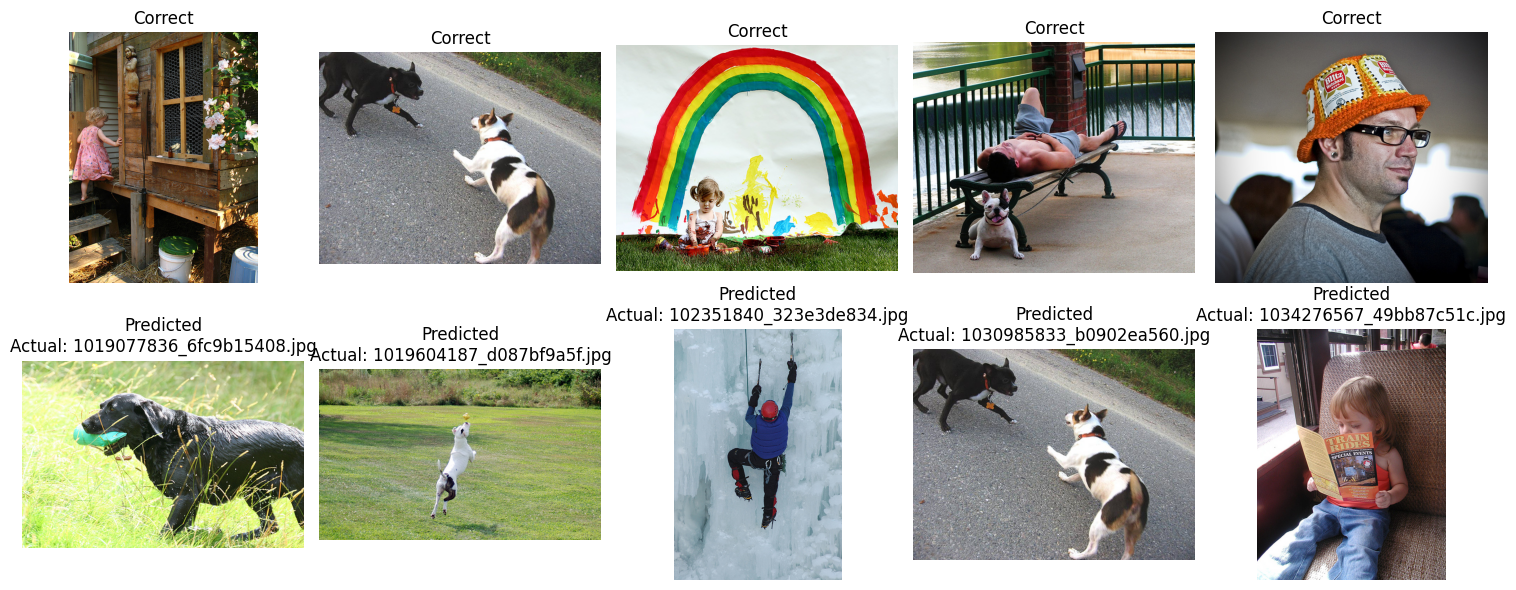

In [ ]:
img_enc = ImageEncoder().to(CFG.device)
img_enc.load_state_dict(torch.load("image_enc_epoch4.pth"))
txt_enc = TextEncoder().to(CFG.device)
txt_enc.load_state_dict(torch.load("text_enc_epoch4.pth"))
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

show_text_to_image(img_enc, txt_enc, tokenizer, max_items=50)


In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import torch

@torch.no_grad()
def show_image_with_captions(img_enc, txt_enc, tokenizer, max_images=5):
    # Build embedding tables
    image_embs, text_embs, captions_list, img_names = build_embedding_table(img_enc, txt_enc, tokenizer)
    img_enc.eval(); txt_enc.eval()

    n_show = min(max_images, len(img_names))
    plt.figure(figsize=(15, 6 * n_show))

    for i in range(n_show):
        img_name = img_names[i]
        actual_captions = captions_list[i] if isinstance(captions_list[i], list) else [captions_list[i]]

        # Display the image
        img = Image.open(CFG.images_dir / img_name).convert("RGB")
        plt.subplot(n_show, 2, 2*i+1)
        plt.imshow(img)
        plt.title(f"Image: {img_name}")
        plt.axis("off")

        # Predict caption: find closest text embedding
        img_emb = image_embs[i].unsqueeze(0)  # (1, D)
        sims = img_emb @ text_embs.t()
        top_idx = torch.argmax(sims).item()
        predicted_caption = captions_list[top_idx]

        # Display predicted caption and ground truth
        plt.subplot(n_show, 2, 2*i+2)
        plt.text(0.5, 0.6, f"Predicted:\n{predicted_caption}", ha="center", va="center", fontsize=12, wrap=True)
        plt.text(0.5, 0.3, "Original captions:\n" + "\n".join(actual_captions),
                 ha="center", va="center", fontsize=10, wrap=True)
        plt.axis("off")

    plt.tight_layout()
    plt.show()


Building tables: 100%|██████████| 8091/8091 [02:35<00:00, 52.11it/s]


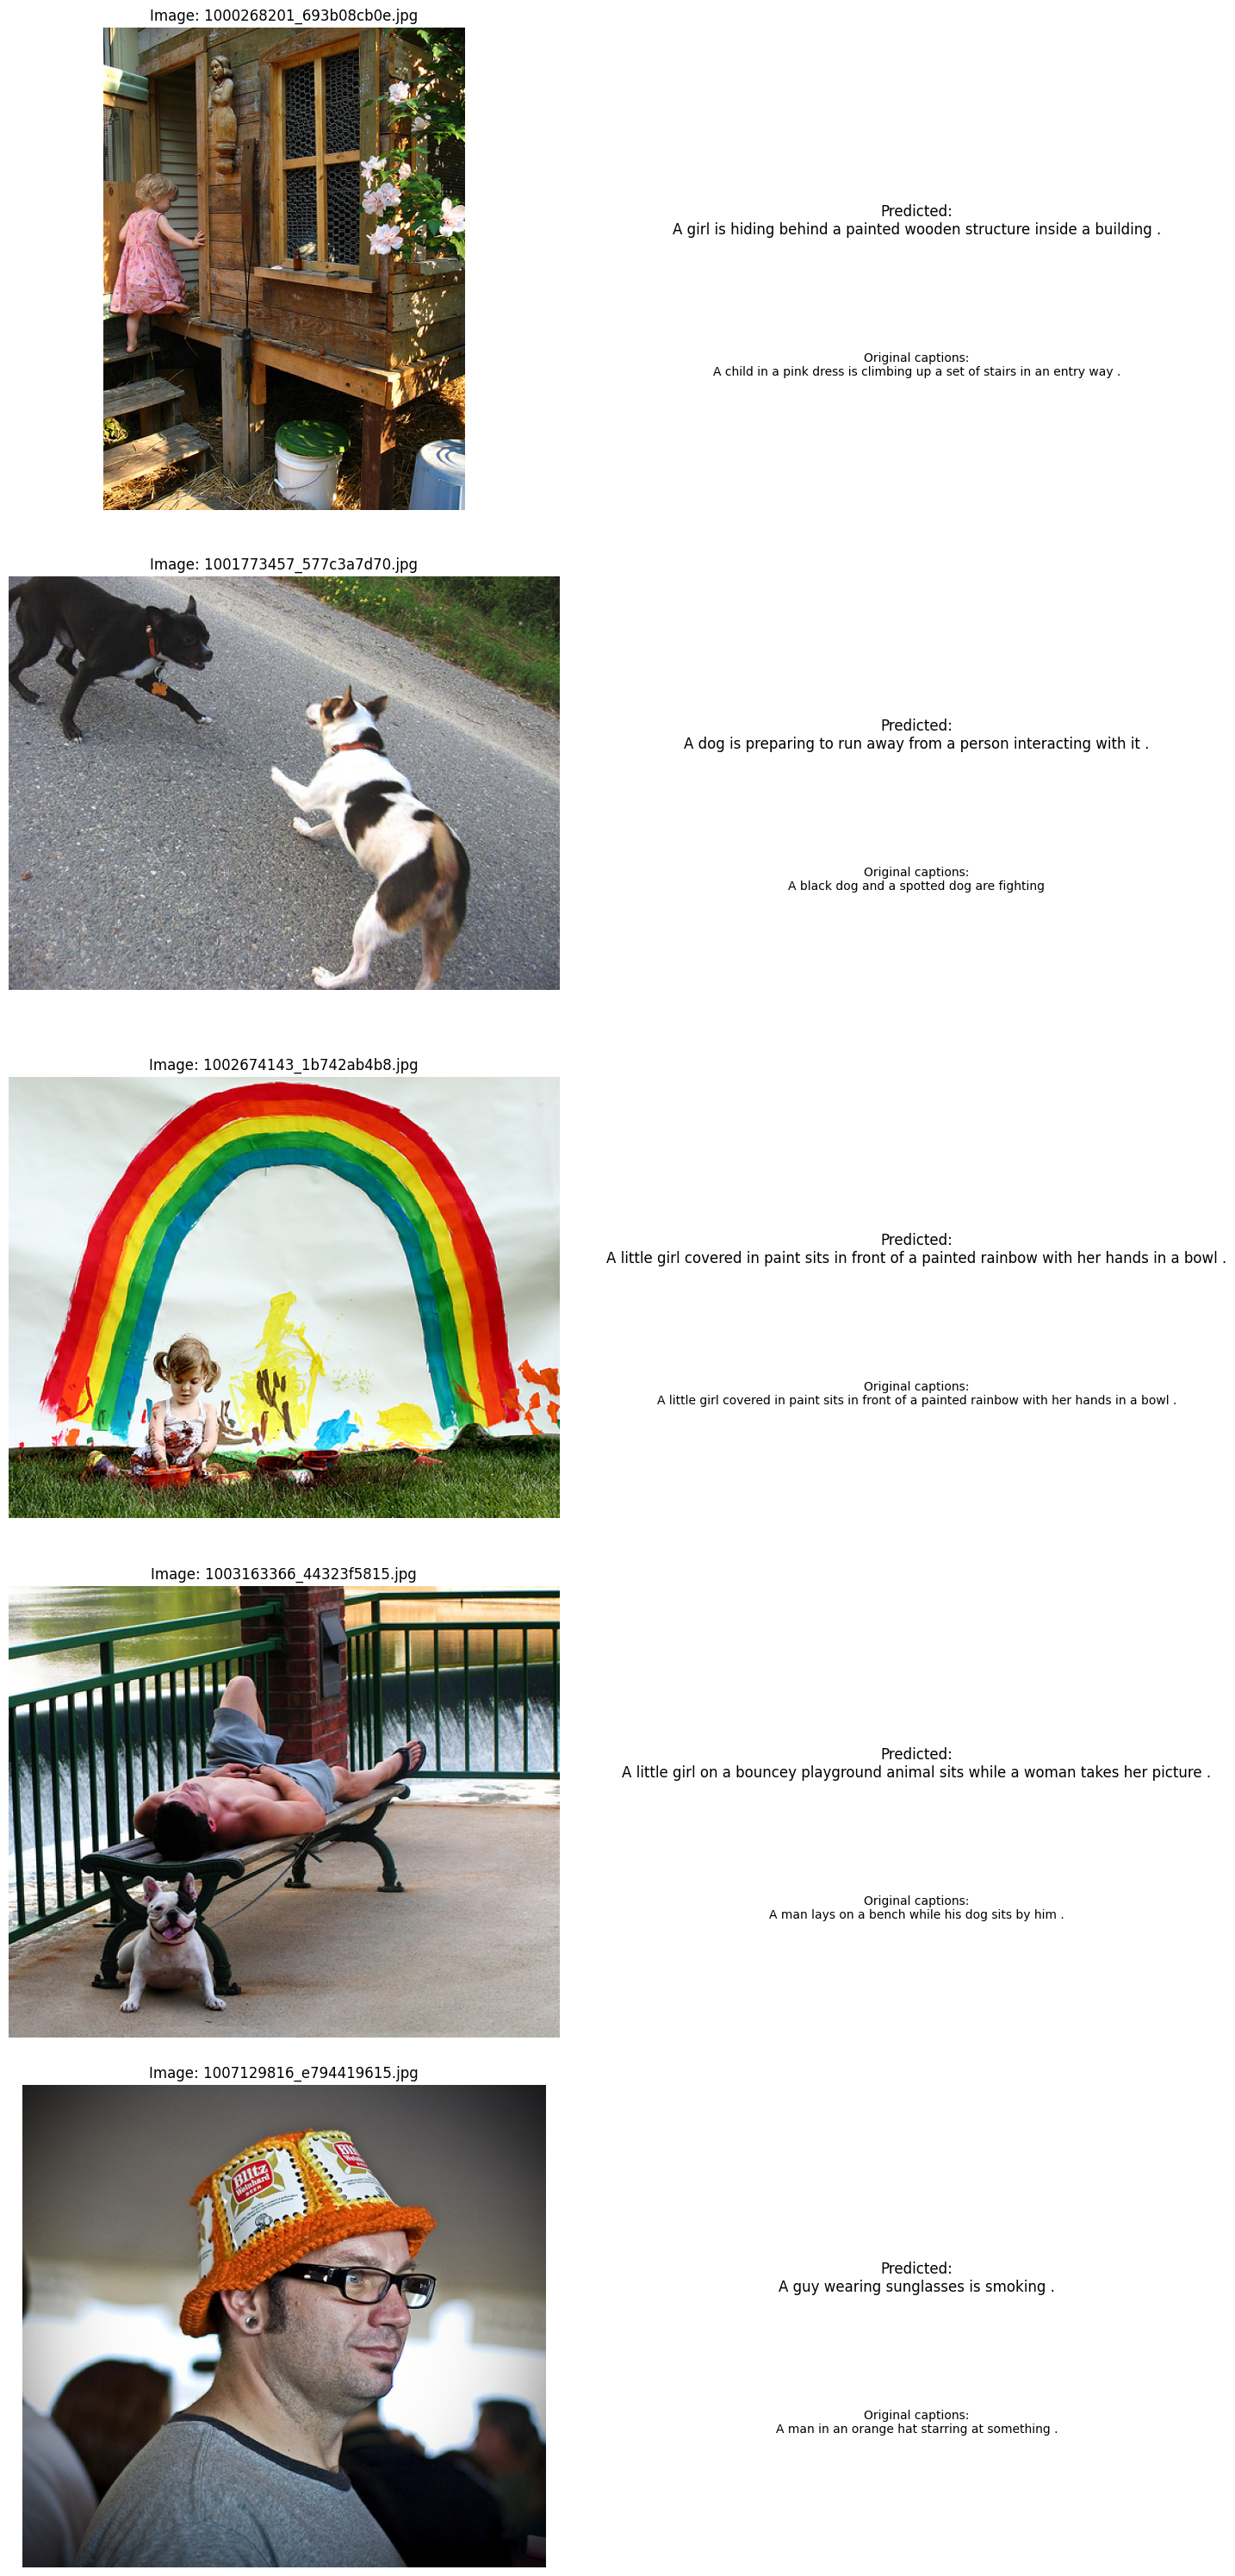

In [ ]:
img_enc = ImageEncoder().to(CFG.device)
img_enc.load_state_dict(torch.load("image_enc_epoch4.pth"))
txt_enc = TextEncoder().to(CFG.device)
txt_enc.load_state_dict(torch.load("text_enc_epoch4.pth"))
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

show_image_with_captions(img_enc, txt_enc, tokenizer, max_images=5)


In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import torch

@torch.no_grad()
def show_image_with_captions_correctness(img_enc, txt_enc, tokenizer, max_images=5):
    # Build embedding tables
    image_embs, text_embs, captions_list, img_names = build_embedding_table(img_enc, txt_enc, tokenizer)
    img_enc.eval(); txt_enc.eval()

    n_show = min(max_images, len(img_names))
    plt.figure(figsize=(15, 6 * n_show))

    for i in range(n_show):
        img_name = img_names[i]
        actual_captions = captions_list[i] if isinstance(captions_list[i], list) else [captions_list[i]]

        # Display the image
        img = Image.open(CFG.images_dir / img_name).convert("RGB")
        plt.subplot(n_show, 2, 2*i+1)
        plt.imshow(img)
        plt.title(f"Image: {img_name}")
        plt.axis("off")

        # Predict caption: find closest text embedding
        img_emb = image_embs[i].unsqueeze(0)  # (1, D)
        sims = img_emb @ text_embs.t()
        top_idx = torch.argmax(sims).item()
        predicted_caption = captions_list[top_idx]

        # Check correctness
        is_correct = predicted_caption in actual_captions
        color = "green" if is_correct else "red"

        # Display predicted caption and ground truth
        plt.subplot(n_show, 2, 2*i+2)
        plt.text(0.5, 0.6, f"Predicted:\n{predicted_caption}", ha="center", va="center", fontsize=12, wrap=True, color=color)
        plt.text(0.5, 0.3, "Original captions:\n" + "\n".join(actual_captions),
                 ha="center", va="center", fontsize=10, wrap=True)
        plt.axis("off")

    plt.tight_layout()
    plt.show()


In [ ]:
img_enc = ImageEncoder().to(CFG.device)
img_enc.load_state_dict(torch.load("image_enc_epoch4.pth"))
txt_enc = TextEncoder().to(CFG.device)
txt_enc.load_state_dict(torch.load("text_enc_epoch4.pth"))
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

show_image_with_captions_correctness(img_enc, txt_enc, tokenizer, max_images=5)


Building tables:  96%|█████████▌| 7765/8091 [02:46<00:06, 52.45it/s]

In [ ]:
train_loader, val_loader, test_loader, tokenizer = build_dataloaders()

print("Train dataset size:", len(train_loader.dataset))
print("Validation dataset size:", len(val_loader.dataset))
print("Test dataset size:", len(test_loader.dataset))


Dataset: 6000 images available for this split.
Dataset: 1000 images available for this split.
Dataset: 1000 images available for this split.
Train dataset size: 6000
Validation dataset size: 1000
Test dataset size: 1000


Calculating Recall

In [ ]:
# ====================== FINAL EVALUATION ======================
import torch
import torch.nn.functional as F
from tqdm import tqdm
@torch.no_grad()
def evaluate_retrieval(img_encoder, txt_encoder, test_loader, device, topk=(1, 5, 10)):
    img_encoder.eval()
    txt_encoder.eval()

    all_img_embs = []
    all_txt_embs = []

    print("Encoding test images and captions...")
    for images, input_ids, attention_mask, _ in tqdm(test_loader):
        images = images.to(device)
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)

        img_emb = img_encoder(images)
        txt_emb = txt_encoder(input_ids, attention_mask)

        all_img_embs.append(img_emb.cpu())
        all_txt_embs.append(txt_emb.cpu())

    all_img_embs = torch.cat(all_img_embs)   # (1000, 256)
    all_txt_embs = torch.cat(all_txt_embs)   # (1000, 256)

    # L2 normalize, cosine similarity
    all_img_embs = F.normalize(all_img_embs, dim=1)
    all_txt_embs = F.normalize(all_txt_embs, dim=1)

    # Moving everything to the correct device for ranking
    all_img_embs = all_img_embs.to(device)
    all_txt_embs = all_txt_embs.to(device)

    sim_matrix = all_img_embs @ all_txt_embs.T   # (1000, 1000)

    # Image → Text
    ranks_i2t = torch.argsort(sim_matrix, dim=1, descending=True)
    # Text → Image
    ranks_t2i = torch.argsort(sim_matrix, dim=0, descending=True)

    N = sim_matrix.size(0)
    arange = torch.arange(N).to(device)

    def recall_at_k(ranks, k):
        # ranks: (N, N), top-k indices
        correct = (ranks[:, :k] == arange.unsqueeze(1)).any(dim=1)
        return correct.float().mean().item() * 100.0

    print("\n" + "="*65)
    print("        FLICKR8K TEST SET RESULTS (1,000 images)")
    print("="*65)

    for k in topk:
        r_i2t = recall_at_k(ranks_i2t, k)
        r_t2i = recall_at_k(ranks_t2i.T, k)   # transpose
        mean_r = (r_i2t + r_t2i) / 2
        print(f"Image → Text   R@{k:2d} = {r_i2t:6.2f}%")
        print(f"Text → Image   R@{k:2d} = {r_t2i:6.2f}%")
        print(f"Mean R@{k:2d}       = {mean_r:6.2f}%")
        print("-" * 65)

    return {
        "I→T": {f"R@{k}": recall_at_k(ranks_i2t, k) for k in topk},
        "T→I": {f"R@{k}": recall_at_k(ranks_t2i.T, k) for k in topk}
    }

# ====================== RUN IT ======================
# Load your best checkpoint (you have epoch10 saved)
img_enc = ImageEncoder().to(CFG.device)
txt_enc = TextEncoder().to(CFG.device)

img_enc.load_state_dict(torch.load("image_enc_epoch10.pth", map_location=CFG.device))
txt_enc.load_state_dict(torch.load("text_enc_epoch10.pth", map_location=CFG.device))

# Re-build loaders (exactly the same as training)
train_loader, val_loader, test_loader, tokenizer = build_dataloaders()

# Evaluate
results = evaluate_retrieval(img_enc, txt_enc, test_loader, CFG.device)

Dataset: 6000 images available for this split.
Dataset: 1000 images available for this split.
Dataset: 1000 images available for this split.
Encoding test images and captions...


100%|██████████| 32/32 [00:06<00:00,  5.20it/s]


        FLICKR8K TEST SET RESULTS (1,000 images)
Image → Text   R@ 1 =  19.10%
Text → Image   R@ 1 =  17.00%
Mean R@ 1       =  18.05%
-----------------------------------------------------------------
Image → Text   R@ 5 =  47.40%
Text → Image   R@ 5 =  46.20%
Mean R@ 5       =  46.80%
-----------------------------------------------------------------
Image → Text   R@10 =  62.60%
Text → Image   R@10 =  60.20%
Mean R@10       =  61.40%
-----------------------------------------------------------------


Loss Cutrve

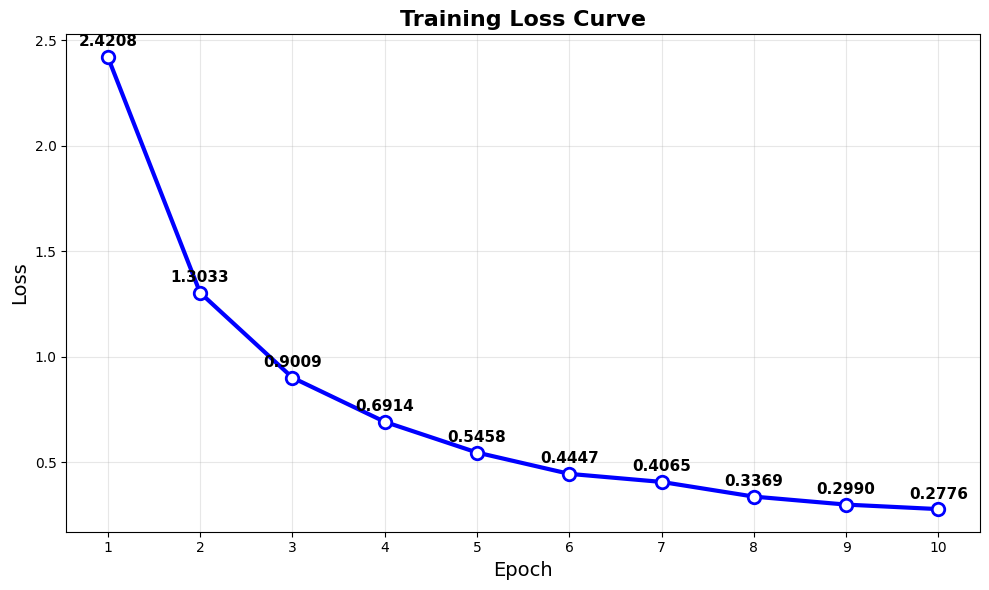

In [ ]:
# YOUR FINAL CLEAN LOSS CURVE – 100% WORKS
import matplotlib.pyplot as plt

# Your exact losses from training
losses = [2.4208, 1.3033, 0.9009, 0.6914, 0.5458, 0.4447, 0.4065, 0.3369, 0.2990, 0.2776]
epochs = list(range(1, 11))

plt.figure(figsize=(10, 6))
plt.plot(epochs, losses, 'o-', color='blue', linewidth=3, markersize=9, markerfacecolor='white', markeredgewidth=2)
plt.title('Training Loss Curve', fontsize=16, fontweight='bold')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.grid(True, alpha=0.3)
plt.xticks(epochs)

for i, loss in enumerate(losses):
    plt.text(i+1, loss + 0.05, f'{loss:.4f}', ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig("training_loss_curve.png", dpi=300, bbox_inches='tight')
plt.show()
